In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets and get the indices
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000,
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping], verbose=0)

# Function to predict heatwave for a given date based on historical data and model prediction
def predict_heatwave(input_date):
    selected_data = df[df['time'] == input_date]
    if not selected_data.empty:
        selected_data = selected_data.iloc[0]
        return "Historical Data", selected_data['tavg'], selected_data['tmin'], selected_data['tmax'], selected_data['humid'], selected_data['Heatwave']
    else:
        print(f"No data found for {input_date}. Using LSTM prediction.")

        # Prepare features for prediction
        future_date = pd.DataFrame({'time': [input_date]})
        future_date['time'] = pd.to_datetime(future_date['time'], format='%Y-%m-%d')
        future_date['day_of_year'] = future_date['time'].dt.dayofyear

        # Use historical averages for missing values
        historical_avg_tavg = df['tavg'].mean()
        historical_avg_tmin = df['tmin'].mean()
        historical_avg_tmax = df['tmax'].mean()
        historical_avg_humid = df['humid'].mean()

        future_date['tavg'] = historical_avg_tavg
        future_date['tmin'] = historical_avg_tmin
        future_date['tmax'] = historical_avg_tmax
        future_date['humid'] = historical_avg_humid

        # Scale features
        future_features = future_date[features].values
        future_features_scaled = scaler.transform(future_features)

        # Reshape input data for LSTM (samples, time steps, features)
        future_features_reshaped = future_features_scaled.reshape((future_features_scaled.shape[0], 1, future_features_scaled.shape[1]))

        # Predict using LSTM model
        prediction_prob = model.predict(future_features_reshaped)
        prediction = (prediction_prob > 0.5).astype(int)[0][0]

        return "LSTM Prediction", historical_avg_tavg, historical_avg_tmin, historical_avg_tmax, historical_avg_humid, prediction

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_pred_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

# Function to display confusion matrix
def display_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
                xticklabels=['Predicted No Heatwave', 'Predicted Heatwave'],
                yticklabels=['Actual No Heatwave', 'Actual Heatwave'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

# Function to predict heatwave for the next 5 days based on historical data and LSTM model predictions
def predict_next_5_days(start_date):
    next_5_days = [start_date + pd.Timedelta(days=i) for i in range(5)]
    predictions = []
    for date in next_5_days:
        prediction_type, avg_tavg, avg_tmin, avg_tmax, avg_humid, prediction = predict_heatwave(date)
        predictions.append({
            'date': date,
            'prediction_type': prediction_type,
            'tavg': avg_tavg,
            'tmin': avg_tmin,
            'tmax': avg_tmax,
            'humid': avg_humid,
            'heatwave': prediction
        })
    return predictions

# Main loop to ask user for dates
while True:
    user_input = input("Enter a date (YYYY-MM-DD) to predict heatwave for the next 5 days or 'exit' to quit: ")
    if user_input.lower() == 'exit':
        break
    try:
        input_date = pd.to_datetime(user_input, format='%Y-%m-%d')
        predictions = predict_next_5_days(input_date)

        for prediction in predictions:
            print(f"Prediction for {prediction['date'].strftime('%Y-%m-%d')}:")
            if prediction['prediction_type'] == "Historical Data":
                print("Based on historical data")
            else:
                print("Based on LSTM prediction")
            print(f"  Average Temperature: {prediction['tavg']:.2f} °C")
            print(f"  Min Temperature: {prediction['tmin']:.2f} °C")
            print(f"  Max Temperature: {prediction['tmax']:.2f} °C")
            print(f"  Humidity: {prediction['humid']:.2f} %")
            if prediction['heatwave'] == 1:
                print("  Predicted Heatwave: Yes")
            else:
                print("  Predicted Heatwave: No")
    except ValueError:
        print("Invalid date format. Please enter the date in YYYY-MM-DD format.")

# Plot evaluation metrics
y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

plot_roc_curve(y_test, y_test_pred_prob)
plot_precision_recall_curve(y_test, y_test_pred_prob)
display_confusion_matrix(y_test, y_test_pred)
#nnnnn

C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Prediction for 2021-10-10:
Based on historical data
  Average Temperature: 28.90 °C
  Min Temperature: 23.60 °C
  Max Temperature: 36.20 °C
  Humidity: 60.00 %
  Predicted Heatwave: Yes
Prediction for 2021-10-11:
Based on historical data
  Average Temperature: 28.70 °C
  Min Temperature: 23.40 °C
  Max Temperature: 36.60 °C
  Humidity: 58.00 %
  Predicted Heatwave: No
Prediction for 2021-10-12:
Based on historical data
  Average Temperature: 28.50 °C
  Min Temperature: 23.50 °C
  Max Temperature: 36.00 °C
  Humidity: 60.00 %
  Predicted Heatwave: Yes
Prediction for 2021-10-13:
Based on historical data
  Average Temperature: 27.00 °C
  Min Temperature: 21.80 °C
  Max Temperature: 33.60 °C
  Humidity: 52.00 %
  Predicted Heatwave: No
Prediction for 2021-10-14:
Based on historical data
  Average Temperature: 26.00 °C
  Min Temperature: 20.60 °C
  Max Temperature: 33.80 °C
  Humidity: 55.00 %
  Predicted Heatwave: No
No data found for 2025-05-05 00:00:00. Using LSTM prediction.
1/1 ━━━━━━━

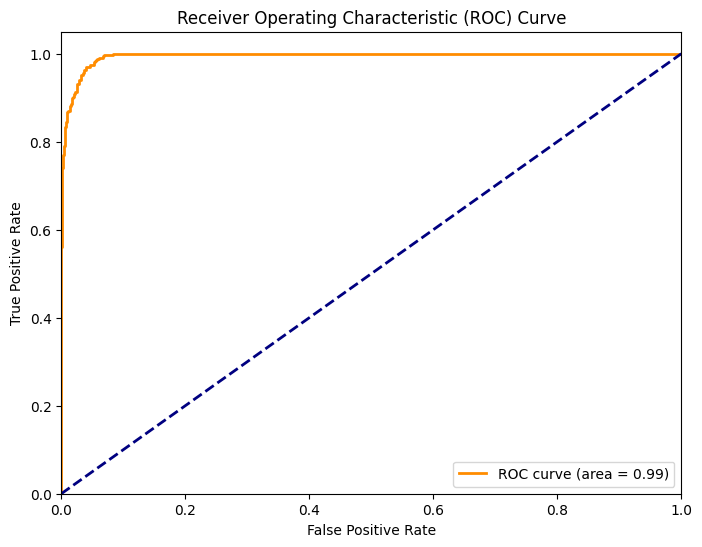

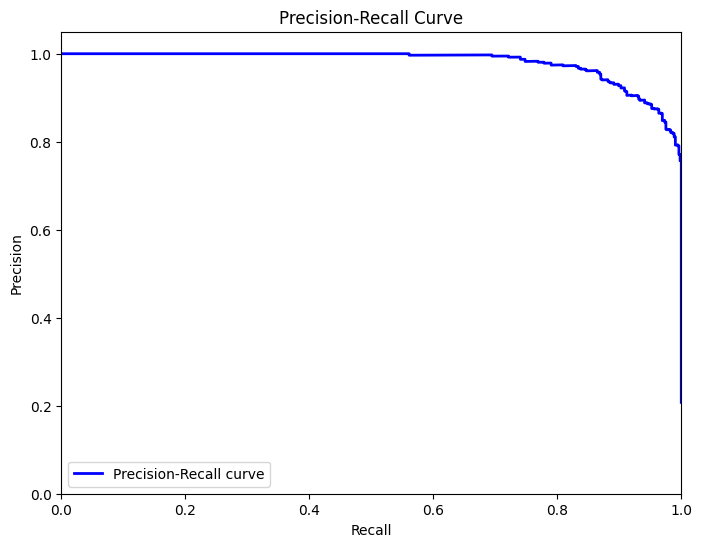

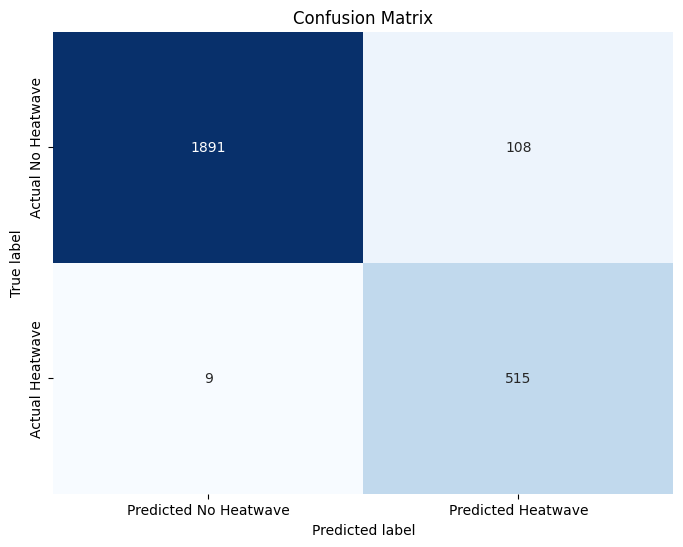

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets and get the indices
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000,
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping], verbose=0)

# Function to predict heatwave for a given date based on historical data and model prediction
def predict_heatwave(input_date):
    selected_data = df[df['time'] == input_date]
    if not selected_data.empty:
        selected_data = selected_data.iloc[0]
        return "Historical Data", selected_data['tavg'], selected_data['tmin'], selected_data['tmax'], selected_data['humid'], selected_data['Heatwave']
    else:
        print(f"No data found for {input_date}. Using LSTM prediction.")

        # Prepare features for prediction
        past_week_data = df[df['time'] < input_date].tail(7)
        if past_week_data.empty:
            # Use historical averages if there's no past data
            avg_tavg = df['tavg'].mean()
            avg_tmin = df['tmin'].mean()
            avg_tmax = df['tmax'].mean()
            avg_humid = df['humid'].mean()
        else:
            avg_tavg = past_week_data['tavg'].mean()
            avg_tmin = past_week_data['tmin'].mean()
            avg_tmax = past_week_data['tmax'].mean()
            avg_humid = past_week_data['humid'].mean()

        # Scale features
        future_features = np.array([[avg_tavg, avg_tmin, avg_tmax, avg_humid]])
        future_features_scaled = scaler.transform(future_features)

        # Reshape input data for LSTM (samples, time steps, features)
        future_features_reshaped = future_features_scaled.reshape((future_features_scaled.shape[0], 1, future_features_scaled.shape[1]))

        # Predict using LSTM model
        prediction_prob = model.predict(future_features_reshaped)
        prediction = (prediction_prob > 0.5).astype(int)[0][0]

        return "LSTM Prediction", avg_tavg, avg_tmin, avg_tmax, avg_humid, prediction

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_pred_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

# Function to display confusion matrix
def display_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
                xticklabels=['Predicted No Heatwave', 'Predicted Heatwave'],
                yticklabels=['Actual No Heatwave', 'Actual Heatwave'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

# Function to predict heatwave for the next 5 days based on historical data and LSTM model predictions
def predict_next_5_days(start_date):
    next_5_days = [start_date + pd.Timedelta(days=i) for i in range(5)]
    predictions = []
    for date in next_5_days:
        prediction_type, avg_tavg, avg_tmin, avg_tmax, avg_humid, prediction = predict_heatwave(date)
        predictions.append({
            'date': date,
            'prediction_type': prediction_type,
            'tavg': avg_tavg,
            'tmin': avg_tmin,
            'tmax': avg_tmax,
            'humid': avg_humid,
            'heatwave': prediction
        })
    return predictions

# Main loop to ask user for dates
while True:
    user_input = input("Enter a date (YYYY-MM-DD) to predict heatwave for the next 5 days or 'exit' to quit: ")
    if user_input.lower() == 'exit':
        break
    try:
        input_date = pd.to_datetime(user_input, format='%Y-%m-%d')
        predictions = predict_next_5_days(input_date)

        for prediction in predictions:
            print(f"Prediction for {prediction['date'].strftime('%Y-%m-%d')}:")
            if prediction['prediction_type'] == "Historical Data":
                print("Based on historical data")
            else:
                print("Based on LSTM prediction")
            print(f"  Average Temperature: {prediction['tavg']:.2f} °C")
            print(f"  Min Temperature: {prediction['tmin']:.2f} °C")
            print(f"  Max Temperature: {prediction['tmax']:.2f} °C")
            print(f"  Humidity: {prediction['humid']:.2f} %")
            if prediction['heatwave'] == 1:
                print("  Predicted Heatwave: Yes")
            else:
                print("  Predicted Heatwave: No")
    except ValueError:
        print("Invalid date format. Please enter the date in YYYY-MM-DD format.")

# Plot evaluation metrics
y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

plot_roc_curve(y_test, y_test_pred_prob)
plot_precision_recall_curve(y_test, y_test_pred_prob)
display_confusion_matrix(y_test, y_test_pred)


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets and get the indices
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000,
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping], verbose=0)

# Function to predict heatwave for a given date based on historical data and model prediction
def predict_heatwave(input_date, df, scaler, model):
    selected_data = df[df['time'] == input_date]
    if not selected_data.empty:
        selected_data = selected_data.iloc[0]
        return "Historical Data", selected_data['tavg'], selected_data['tmin'], selected_data['tmax'], selected_data['humid'], selected_data['Heatwave']
    else:
        print(f"No data found for {input_date}. Using LSTM prediction.")

        # Prepare features for prediction
        past_week_data = df[df['time'] < input_date].tail(7)
        if past_week_data.empty:
            # Use historical averages if there's no past data
            avg_tavg = df['tavg'].mean()
            avg_tmin = df['tmin'].mean()
            avg_tmax = df['tmax'].mean()
            avg_humid = df['humid'].mean()
        else:
            avg_tavg = past_week_data['tavg'].mean()
            avg_tmin = past_week_data['tmin'].mean()
            avg_tmax = past_week_data['tmax'].mean()
            avg_humid = past_week_data['humid'].mean()

        # Scale features
        future_features = np.array([[avg_tavg, avg_tmin, avg_tmax, avg_humid]])
        future_features_scaled = scaler.transform(future_features)

        # Reshape input data for LSTM (samples, time steps, features)
        future_features_reshaped = future_features_scaled.reshape((future_features_scaled.shape[0], 1, future_features_scaled.shape[1]))

        # Predict using LSTM model
        prediction_prob = model.predict(future_features_reshaped)
        prediction = (prediction_prob > 0.5).astype(int)[0][0]

        return "LSTM Prediction", avg_tavg, avg_tmin, avg_tmax, avg_humid, prediction

# Function to predict heatwave for the next 5 days based on historical data and LSTM model predictions
def predict_next_5_days(start_date, df, scaler, model):
    next_5_days = [start_date + pd.Timedelta(days=i) for i in range(5)]
    predictions = []
    for date in next_5_days:
        prediction_type, avg_tavg, avg_tmin, avg_tmax, avg_humid, prediction = predict_heatwave(date, df, scaler, model)
        predictions.concat({
            'date': date,
            'prediction_type': prediction_type,
            'tavg': avg_tavg,
            'tmin': avg_tmin,
            'tmax': avg_tmax,
            'humid': avg_humid,
            'heatwave': prediction
        })
        # Append the predicted values to the dataframe for next day's prediction
        df = df.concat({
            'time': date,
            'tavg': avg_tavg,
            'tmin': avg_tmin,
            'tmax': avg_tmax,
            'humid': avg_humid,
            'Heatwave': prediction
        }, ignore_index=True)
    return predictions

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_pred_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

# Function to display confusion matrix
def display_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
                xticklabels=['Predicted No Heatwave', 'Predicted Heatwave'],
                yticklabels=['Actual No Heatwave', 'Actual Heatwave'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

# Main loop to ask user for dates
while True:
    user_input = input("Enter a date (YYYY-MM-DD) to predict heatwave for the next 5 days or 'exit' to quit: ")
    if user_input.lower() == 'exit':
        break
    try:
        input_date = pd.to_datetime(user_input, format='%Y-%m-%d')
        predictions = predict_next_5_days(input_date, df.copy(), scaler, model)

        for prediction in predictions:
            print(f"Prediction for {prediction['date'].strftime('%Y-%m-%d')}:")
            if prediction['prediction_type'] == "Historical Data":
                print("Based on historical data")
            else:
                print("Based on LSTM prediction")
            print(f"  Average Temperature: {prediction['tavg']:.2f} °C")
            print(f"  Min Temperature: {prediction['tmin']:.2f} °C")
            print(f"  Max Temperature: {prediction['tmax']:.2f} °C")
            print(f"  Humidity: {prediction['humid']:.2f} %")
            if prediction['heatwave'] == 1:
                print("  Predicted Heatwave: Yes")
            else:
                print("  Predicted Heatwave: No")
    except ValueError:
        print("Invalid date format. Please enter the date in YYYY-MM-DD format.")

# Evaluate model on test set
y_test_pred_prob = model.predict(X_test).ravel()
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Plot ROC curve
plot_roc_curve(y_test, y_test_pred_prob)

# Plot Precision-Recall curve
plot_precision_recall_curve(y_test, y_test_pred_prob)

# Display confusion matrix
display_confusion_matrix(y_test, y_test_pred)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


No data found for 2025-08-08 00:00:00. Using LSTM prediction.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


AttributeError: 'list' object has no attribute 'concat'

C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


No data found for 2025-08-08 00:00:00. Using LSTM prediction.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
No data found for 2025-08-09 00:00:00. Using LSTM prediction.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
No data found for 2025-08-10 00:00:00. Using LSTM prediction.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
No data found for 2025-08-11 00:00:00. Using LSTM prediction.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
No data found for 2025-08-12 00:00:00. Using LSTM prediction.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for 2025-08-08:
Based on LSTM prediction
  Average Temperature: 30.14 °C
  Min Temperature: 27.71 °C
  Max Temperature: 33.84 °C
  Humidity: 82.43 %
  Predicted Heatwave: Yes
Prediction for 2025-08-09:
Based on LSTM prediction
  Average Temperature: 30.22 °C
  Min Temperature: 27.67 °C
  Max Temperature: 34.11 °C
  Humidity: 81.63 %
  Predicted Heatwave: Yes
Prediction for 2025-08-10:
Based on LSTM prediction
  Average Temperature: 30.32 °C
  Min Temperature: 27.63 °C
  Max Temperatu

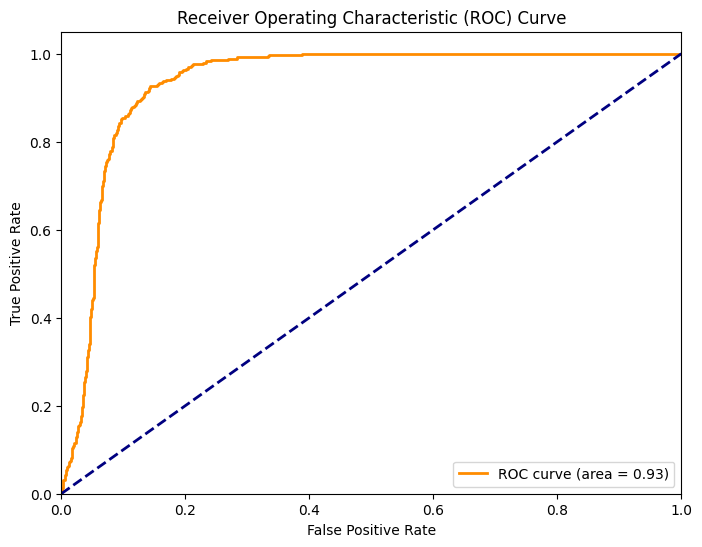

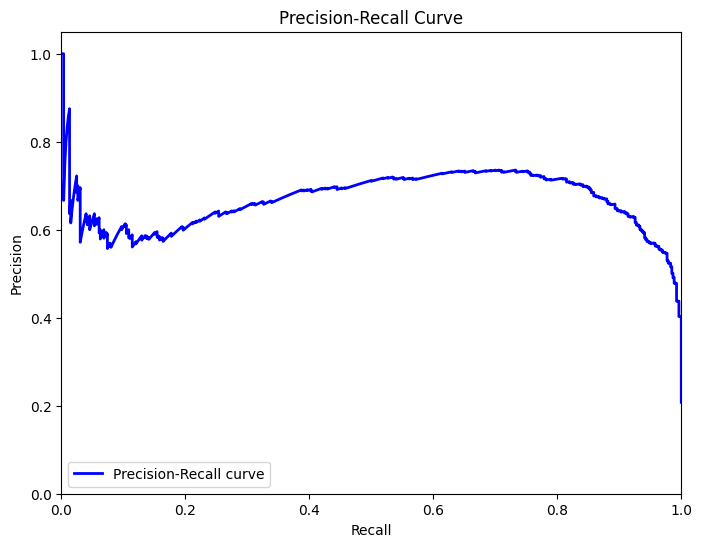

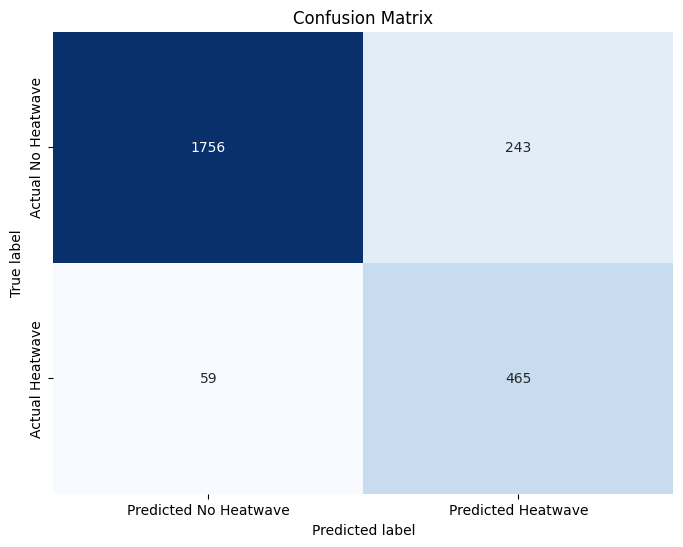

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      1999
           1       0.66      0.89      0.75       524

    accuracy                           0.88      2523
   macro avg       0.81      0.88      0.84      2523
weighted avg       0.90      0.88      0.89      2523



In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets and get the indices
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000,
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping], verbose=0)

# Function to predict heatwave for a given date based on historical data and model prediction
def predict_heatwave(input_date, df, scaler, model):
    selected_data = df[df['time'] == input_date]
    if not selected_data.empty:
        selected_data = selected_data.iloc[0]
        return "Historical Data", selected_data['tavg'], selected_data['tmin'], selected_data['tmax'], selected_data['humid'], selected_data['Heatwave']
    else:
        print(f"No data found for {input_date}. Using LSTM prediction.")

        # Prepare features for prediction
        past_week_data = df[df['time'] < input_date].tail(7)
        if past_week_data.empty:
            # Use historical averages if there's no past data
            avg_tavg = df['tavg'].mean()
            avg_tmin = df['tmin'].mean()
            avg_tmax = df['tmax'].mean()
            avg_humid = df['humid'].mean()
        else:
            avg_tavg = past_week_data['tavg'].mean()
            avg_tmin = past_week_data['tmin'].mean()
            avg_tmax = past_week_data['tmax'].mean()
            avg_humid = past_week_data['humid'].mean()

        # Scale features
        future_features = np.array([[avg_tavg, avg_tmin, avg_tmax, avg_humid]])
        future_features_scaled = scaler.transform(future_features)

        # Reshape input data for LSTM (samples, time steps, features)
        future_features_reshaped = future_features_scaled.reshape((future_features_scaled.shape[0], 1, future_features_scaled.shape[1]))

        # Predict using LSTM model
        prediction_prob = model.predict(future_features_reshaped)
        prediction = (prediction_prob > 0.5).astype(int)[0][0]

        return "LSTM Prediction", avg_tavg, avg_tmin, avg_tmax, avg_humid, prediction

# Function to predict heatwave for the next 5 days based on historical data and LSTM model predictions
def predict_next_5_days(start_date, df, scaler, model):
    next_5_days = [start_date + pd.Timedelta(days=i) for i in range(5)]
    predictions = []
    for date in next_5_days:
        prediction_type, avg_tavg, avg_tmin, avg_tmax, avg_humid, prediction = predict_heatwave(date, df, scaler, model)
        predictions.append({
            'date': date,
            'prediction_type': prediction_type,
            'tavg': avg_tavg,
            'tmin': avg_tmin,
            'tmax': avg_tmax,
            'humid': avg_humid,
            'heatwave': prediction
        })
        # Append the predicted values to the dataframe for next day's prediction
        new_row = pd.DataFrame([{
            'time': date,
            'tavg': avg_tavg,
            'tmin': avg_tmin,
            'tmax': avg_tmax,
            'humid': avg_humid,
            'Heatwave': prediction
        }])
        df = pd.concat([df, new_row], ignore_index=True)
    return predictions

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_pred_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

# Function to display confusion matrix
def display_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
                xticklabels=['Predicted No Heatwave', 'Predicted Heatwave'],
                yticklabels=['Actual No Heatwave', 'Actual Heatwave'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

# Main loop to ask user for dates
while True:
    user_input = input("Enter a date (YYYY-MM-DD) to predict heatwave for the next 5 days or 'exit' to quit: ")
    if user_input.lower() == 'exit':
        break
    try:
        input_date = pd.to_datetime(user_input, format='%Y-%m-%d')
        predictions = predict_next_5_days(input_date, df, scaler, model)
        for prediction in predictions:
            print(f"Prediction for {prediction['date'].strftime('%Y-%m-%d')}:")
            if prediction['prediction_type'] == "Historical Data":
                print("Based on historical data")
            else:
                print("Based on LSTM prediction")
            print(f"  Average Temperature: {prediction['tavg']:.2f} °C")
            print(f"  Min Temperature: {prediction['tmin']:.2f} °C")
            print(f"  Max Temperature: {prediction['tmax']:.2f} °C")
            print(f"  Humidity: {prediction['humid']:.2f} %")
            if prediction['heatwave'] == 1:
                print("  Predicted Heatwave: Yes")
            else:
                print("  Predicted Heatwave: No")
    except ValueError:
        print("Invalid date format. Please enter the date in YYYY-MM-DD format.")

# Evaluate model on test set
y_test_pred_prob = model.predict(X_test).ravel()
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Plot ROC curve
plot_roc_curve(y_test, y_test_pred_prob)

# Plot Precision-Recall curve
plot_precision_recall_curve(y_test, y_test_pred_prob)

# Display confusion matrix
display_confusion_matrix(y_test, y_test_pred)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


No data found for 2025-06-06 00:00:00. Using LSTM prediction.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
No data found for 2025-06-07 00:00:00. Using LSTM prediction.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
No data found for 2025-06-08 00:00:00. Using LSTM prediction.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
No data found for 2025-06-09 00:00:00. Using LSTM prediction.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
No data found for 2025-06-10 00:00:00. Using LSTM prediction.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Prediction for 2025-06-06:
Based on LSTM prediction
  Average Temperature: 30.14 °C
  Min Temperature: 27.71 °C
  Max Temperature: 33.84 °C
  Humidity: 82.43 %
  Predicted Heatwave: Yes
Prediction for 2025-06-07:
Based on LSTM prediction
  Average Temperature: 30.22 °C
  Min Temperature: 27.67 °C
  Max Temperature: 34.11 °C
  Humidity: 81.63 %
  Predicted Heatwave: Yes
Prediction for 2025-06-08:
Based on LSTM prediction
  Average Temperature: 30.32 °C
  Min Temperature: 27.63 °C
  Max Temperatu

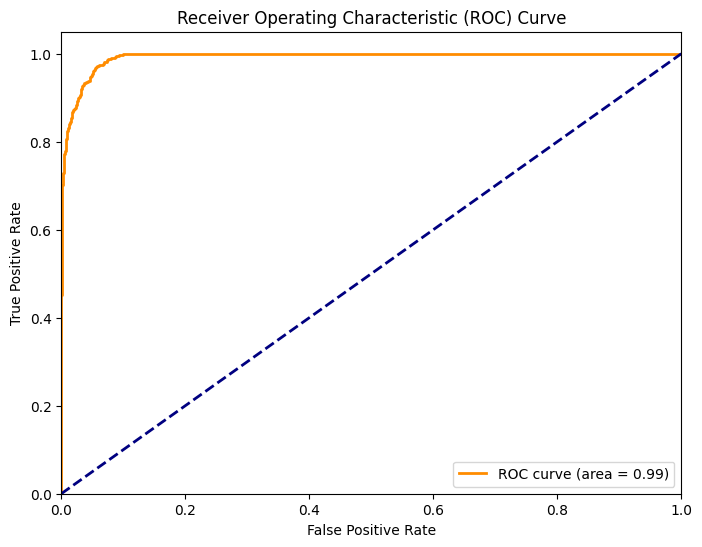

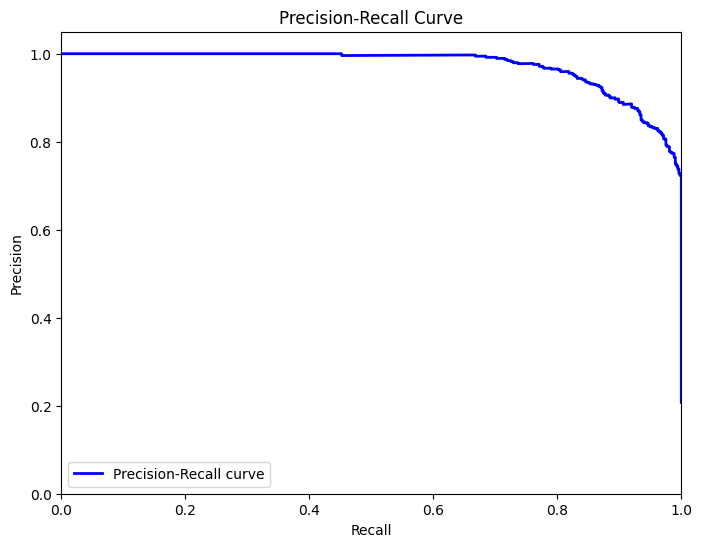

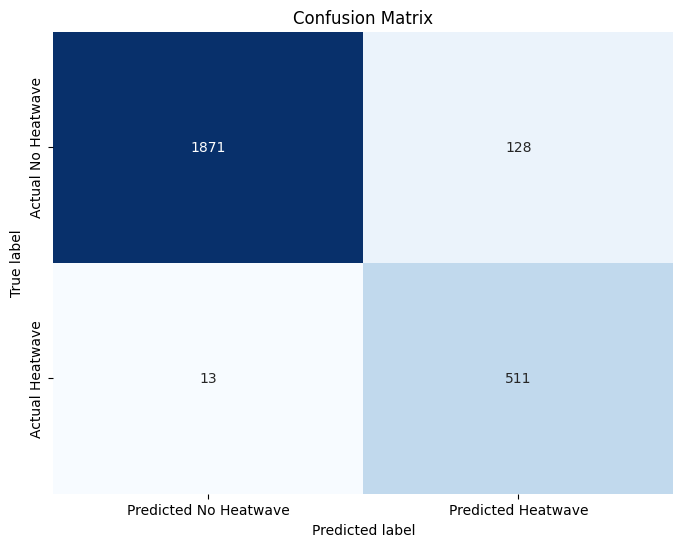

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1999
           1       0.80      0.98      0.88       524

    accuracy                           0.94      2523
   macro avg       0.90      0.96      0.92      2523
weighted avg       0.95      0.94      0.95      2523



In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets and get the indices
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000,
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping], verbose=0)

# Function to predict heatwave for a given date based on historical data and model prediction
def predict_heatwave(input_date, df, scaler, model):
    selected_data = df[df['time'] == input_date]
    if not selected_data.empty:
        selected_data = selected_data.iloc[0]
        return "Historical Data", selected_data['tavg'], selected_data['tmin'], selected_data['tmax'], selected_data['humid'], selected_data['Heatwave']
    else:
        print(f"No data found for {input_date}. Using LSTM prediction.")

        # Prepare features for prediction
        past_week_data = df[df['time'] < input_date].tail(7)
        if past_week_data.empty:
            # Use historical averages if there's no past data
            avg_tavg = df['tavg'].mean()
            avg_tmin = df['tmin'].mean()
            avg_tmax = df['tmax'].mean()
            avg_humid = df['humid'].mean()
        else:
            avg_tavg = past_week_data['tavg'].mean()
            avg_tmin = past_week_data['tmin'].mean()
            avg_tmax = past_week_data['tmax'].mean()
            avg_humid = past_week_data['humid'].mean()

        # Scale features
        future_features = np.array([[avg_tavg, avg_tmin, avg_tmax, avg_humid]])
        future_features_scaled = scaler.transform(future_features)

        # Reshape input data for LSTM (samples, time steps, features)
        future_features_reshaped = future_features_scaled.reshape((future_features_scaled.shape[0], 1, future_features_scaled.shape[1]))

        # Predict using LSTM model
        prediction_prob = model.predict(future_features_reshaped)
        prediction = (prediction_prob > 0.5).astype(int)[0][0]

        return "LSTM Prediction", avg_tavg, avg_tmin, avg_tmax, avg_humid, prediction

# Function to predict heatwave for the next 5 days based on historical data and LSTM model predictions
def predict_next_5_days(start_date, df, scaler, model):
    next_5_days = [start_date + pd.Timedelta(days=i) for i in range(5)]
    predictions = []
    for date in next_5_days:
        prediction_type, avg_tavg, avg_tmin, avg_tmax, avg_humid, prediction = predict_heatwave(date, df, scaler, model)
        predictions.append({
            'date': date,
            'prediction_type': prediction_type,
            'tavg': avg_tavg,
            'tmin': avg_tmin,
            'tmax': avg_tmax,
            'humid': avg_humid,
            'heatwave': prediction
        })
        if prediction_type == "LSTM Prediction":
            # Append the predicted values to the dataframe for next day's prediction
            new_row = pd.DataFrame([{
                'time': date,
                'tavg': avg_tavg,
                'tmin': avg_tmin,
                'tmax': avg_tmax,
                'humid': avg_humid,
                'Heatwave': prediction
            }])
            df = pd.concat([df, new_row], ignore_index=True)
    return predictions

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_pred_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

# Function to display confusion matrix
def display_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
                xticklabels=['Predicted No Heatwave', 'Predicted Heatwave'],
                yticklabels=['Actual No Heatwave', 'Actual Heatwave'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

# Main loop to ask user for dates
while True:
    user_input = input("Enter a date (YYYY-MM-DD) to predict heatwave for the next 5 days or 'exit' to quit: ")
    if user_input.lower() == 'exit':
        break
    try:
        input_date = pd.to_datetime(user_input, format='%Y-%m-%d')
        predictions = predict_next_5_days(input_date, df, scaler, model)
        for prediction in predictions:
            print(f"Prediction for {prediction['date'].strftime('%Y-%m-%d')}:")
            if prediction['prediction_type'] == "Historical Data":
                print("Based on historical data")
            else:
                print("Based on LSTM prediction")
            print(f"  Average Temperature: {prediction['tavg']:.2f} °C")
            print(f"  Min Temperature: {prediction['tmin']:.2f} °C")
            print(f"  Max Temperature: {prediction['tmax']:.2f} °C")
            print(f"  Humidity: {prediction['humid']:.2f} %")
            if prediction['heatwave'] == 1:
                print("  Predicted Heatwave: Yes")
            else:
                print("  Predicted Heatwave: No")
    except ValueError:
        print("Invalid date format. Please enter the date in YYYY-MM-DD format.")

# Evaluate model on test set
y_test_pred_prob = model.predict(X_test).ravel()
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Plot ROC curve
plot_roc_curve(y_test, y_test_pred_prob)

# Plot Precision-Recall curve
plot_precision_recall_curve(y_test, y_test_pred_prob)

# Display confusion matrix
display_confusion_matrix(y_test, y_test_pred)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))
#ok this is fine now 


In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets and get the indices
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=1000,
                    validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)

# Function to predict heatwave for a given date based on historical data and model prediction
def predict_heatwave(input_date, df, scaler, model):
    selected_data = df[df['time'] == input_date]
    if not selected_data.empty:
        selected_data = selected_data.iloc[0]
        return "Historical Data", selected_data['tavg'], selected_data['tmin'], selected_data['tmax'], selected_data['humid'], selected_data['Heatwave']
    else:
        print(f"No data found for {input_date}. Using LSTM prediction.")

        # Prepare features for prediction
        past_week_data = df[df['time'] < input_date].tail(7)
        if past_week_data.empty:
            # Use historical averages if there's no past data
            avg_tavg = df['tavg'].mean()
            avg_tmin = df['tmin'].mean()
            avg_tmax = df['tmax'].mean()
            avg_humid = df['humid'].mean()
        else:
            avg_tavg = past_week_data['tavg'].mean()
            avg_tmin = past_week_data['tmin'].mean()
            avg_tmax = past_week_data['tmax'].mean()
            avg_humid = past_week_data['humid'].mean()

        # Scale features
        future_features = np.array([[avg_tavg, avg_tmin, avg_tmax, avg_humid]])
        future_features_scaled = scaler.transform(future_features)

        # Reshape input data for LSTM (samples, time steps, features)
        future_features_reshaped = future_features_scaled.reshape((future_features_scaled.shape[0], 1, future_features_scaled.shape[1]))

        # Predict using LSTM model
        prediction_prob = model.predict(future_features_reshaped)
        prediction = (prediction_prob > 0.5).astype(int)[0][0]

        return "LSTM Prediction", avg_tavg, avg_tmin, avg_tmax, avg_humid, prediction

# Function to predict heatwave for the next 5 days based on historical data and LSTM model predictions
def predict_next_5_days(start_date, df, scaler, model):
    latest_date = df['time'].max()
    next_5_days = [start_date + pd.Timedelta(days=i) for i in range(5)]
    predictions = []
    for date in next_5_days:
        if date <= latest_date:
            # Use actual data if date exists in the dataset
            prediction_type, avg_tavg, avg_tmin, avg_tmax, avg_humid, prediction = predict_heatwave(date, df, scaler, model)
        else:
            # Predict using LSTM for future dates
            prediction_type, avg_tavg, avg_tmin, avg_tmax, avg_humid, prediction = predict_heatwave(date, df, scaler, model)
        
        predictions.append({
            'date': date,
            'prediction_type': prediction_type,
            'tavg': avg_tavg,
            'tmin': avg_tmin,
            'tmax': avg_tmax,
            'humid': avg_humid,
            'heatwave': prediction
        })
        if prediction_type == "LSTM Prediction":
            # Append the predicted values to the dataframe for next day's prediction
            new_row = pd.DataFrame([{
                'time': date,
                'tavg': avg_tavg,
                'tmin': avg_tmin,
                'tmax': avg_tmax,
                'humid': avg_humid,
                'Heatwave': prediction
            }])
            df = pd.concat([df, new_row], ignore_index=True)
    return predictions

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_pred_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

# Function to display confusion matrix
def display_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
                xticklabels=['Predicted No Heatwave', 'Predicted Heatwave'],
                yticklabels=['Actual No Heatwave', 'Actual Heatwave'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

# Main loop to ask user for dates
while True:
    user_input = input("Enter a date (YYYY-MM-DD) to predict heatwave for the next 5 days or 'exit' to quit: ")
    if user_input.lower() == 'exit':
        break
    try:
        input_date = pd.to_datetime(user_input, format='%Y-%m-%d')
        predictions = predict_next_5_days(input_date, df, scaler, model)
        for prediction in predictions:
            print(f"Prediction for {prediction['date'].strftime('%Y-%m-%d')}:")
            if prediction['prediction_type'] == "Historical Data":
                print("Based on historical data")
            else:
                print("Based on LSTM prediction")
            print(f"  Average Temperature: {prediction['tavg']:.2f} °C")
            print(f"  Min Temperature: {prediction['tmin']:.2f} °C")
            print(f"  Max Temperature: {prediction['tmax']:.2f} °C")
            print(f"  Humidity: {prediction['humid']:.2f} %")
            if prediction['heatwave'] == 1:
                print("  Predicted Heatwave: Yes")
            else:
                print("  Predicted Heatwave: No")
    except ValueError:
        print("Invalid date format. Please enter the date in YYYY-MM-DD format.")

# Evaluate model on test set
y_test_pred_prob = model.predict(X_test).ravel()
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Plot evaluation metrics
plot_roc_curve(y_test, y_test_pred_prob)
plot_precision_recall_curve(y_test, y_test_pred_prob)
display_confusion_matrix(y_test, y_test_pred)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


No data found for 2025-01-01 00:00:00. Using LSTM prediction.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
No data found for 2025-01-02 00:00:00. Using LSTM prediction.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
No data found for 2025-01-03 00:00:00. Using LSTM prediction.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
No data found for 2025-01-04 00:00:00. Using LSTM prediction.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
No data found for 2025-01-05 00:00:00. Using LSTM prediction.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction for 2025-01-01:
Based on LSTM prediction
  Average Temperature: 30.14 °C
  Min Temperature: 27.71 °C
  Max Temperature: 33.84 °C
  Humidity: 82.43 %
  Predicted Heatwave: Yes
Prediction for 2025-01-02:
Based on LSTM prediction
  Average Temperature: 30.22 °C
  Min Temperature: 27.67 °C
  Max Temperature: 34.11 °C
  Humidity: 81.63 %
  Predicted Heatwave: Yes
Prediction for 2025-01-03:
Based on LSTM prediction
  Average Temperature: 30.32 °C
  Min Temperature: 27.63 °C
  Max Temperatu